# Gathering similar answers (XAI) 

This notebook conducts a semantic similarity analysis to identify which student responses are most similar to a given response. A transformer-based language model is employed to encode student responses into high-dimensional vector representations to enable semantic comparison between responses. Examples of similar answers are given for five student responses of a biology question. 

## Imports

In [25]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import glob
import re

## Load transformer model

This project uses [S-BERT](https://www.sbert.net/), a pre-trained multilingual sentence transformer model that is specifically capable of handling Dutch text (among many other languages). The model is used to:

1. Encode student responses into vector embeddings
2. Encode model answers into the same vector space
3. Calculate similarity between student responses and model answers
4. Support LIME for interpreting predictions


Overall, it enables semantic comparison between student responses and model answers.

In [26]:
multilingual_sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

## Load data

In [27]:
def load_data(csv_path):
    """
    Processes a CSV file containing student responses and separates them into 
    different categories based on scores.
    
    Parameters
    ----------
    csv_path : str
        Path to the CSV file with student response data
        
    Returns
    -------
    tuple
        Contains five DataFrames:
        - all_data: Original data
        - part1: First responses with scores (0/1)
        - part2: Second responses with scores (0/1)
        - part1_complex: First responses with ambiguous scores
        - part2_complex: Second responses with ambiguous scores
        
    Notes
    -----
    - Input CSV must have columns 'O', 'RESPONSE' and 'RESPONSE2'
    """

    data = pd.read_csv(csv_path, sep=";")

    data['RESPONSE'] = data['RESPONSE'].apply(lambda x: clean_response(x))
    data['RESPONSE2'] = data['RESPONSE2'].apply(lambda x: clean_response(x))

    part1 = pd.DataFrame(columns=["RESPONSE", "SCORE"])
    part2 = pd.DataFrame(columns=["RESPONSE", "SCORE"])
    part1_complex = pd.DataFrame(columns=["RESPONSE"])
    part2_complex = pd.DataFrame(columns=["RESPONSE"])

    for _, row in data.iterrows():
        if row['O'] == 2:
            row1 = {'RESPONSE': row['RESPONSE'], 'SCORE': 1}
            row2 = {'RESPONSE': row['RESPONSE2'], 'SCORE': 1}

            part1 = pd.concat([part1, pd.DataFrame([row1])], ignore_index=True)
            part2 = pd.concat([part2, pd.DataFrame([row2])], ignore_index=True)

        elif row['O'] == 0:
            row1 = {'RESPONSE': row['RESPONSE'], 'SCORE': 0}
            row2 = {'RESPONSE': row['RESPONSE2'], 'SCORE': 0}

            part1 = pd.concat([part1, pd.DataFrame([row1])], ignore_index=True)
            part2 = pd.concat([part2, pd.DataFrame([row2])], ignore_index=True)
            
        else:
            resp1 = {'RESPONSE': row['RESPONSE']}
            part1_complex = pd.concat([part1_complex, pd.DataFrame([resp1])], ignore_index=True) 

            resp2 = {'RESPONSE': row['RESPONSE2']}
            part2_complex = pd.concat([part2_complex, pd.DataFrame([resp2])], ignore_index=True)
    
    return data, part1, part2, part1_complex, part2_complex

def clean_response(text):
    """
    Cleans a response by:
    - Converting newlines and carriage returns to spaces
    - Removing HTML-like tags (<p>, </p>, etc.)
    - Normalizing whitespace
    - Converting to lowercase
    
    Parameters
    ----------
    text : str or any
        The student response text to clean
        
    Returns
    -------
    str
        Cleaned text with normalized whitespace
    """
    
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    text = text.replace('\n', '').replace('\r', '')
    text = re.sub(r'</?[a-zA-Z][^>]*>', '', text)
    text = re.sub(r'\s+', ' ', text)

    text = text.strip()
    text = text.lower()
    
    return text

In [28]:
# Retrieve response data from the biology questions 

folder_path = "Data/Data_bio_chosen/"
csv_paths = glob.glob(folder_path + "*.csv")

for file_path in csv_paths:
    df = pd.read_csv(file_path, sep=";")

df = pd.read_csv(csv_paths[0], sep=";")

pd.set_option('display.max_colwidth', 50)
display(df.head())

,RESPONSE,VIDEORESPONSE,RESPONSE3,RESPONSE2,VIDEORESPONSE2,RESPONSE4,VIDEORESPONSE3,Identifier,1,2,O,N,MaxScore,chars
0,Dat het zuurstof meer afneemt en koolstofdiox...,NaN,NaN,Omdat ze dan meer gaan eten dus dan ook meer z...,NaN,NaN,NaN,SCORE,2.0,0.0,2.0,NaN,2,794
1,\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r...,NaN,NaN,\r\n\r\ndoordat er meer zuurstof verbiukplaats...,NaN,NaN,NaN,SCORE,0.0,0.0,0.0,NaN,2,706
2,dat de organismen op en in de bodem van de vij...,NaN,NaN,De organismen op en in de bodem van de vijver ...,NaN,NaN,NaN,SCORE,2.0,2.0,2.0,NaN,2,587
3,Het zuurstof gebruik zal meer worden.,NaN,NaN,Planten kunnen veel energierijke stoffen halen...,NaN,NaN,NaN,SCORE,1.0,2.0,1.0,NaN,2,518
4,er zit minder zuurstof in het water en meer b...,NaN,NaN,wanneer zoveel vieze uitwerpselen in de bode...,NaN,NaN,NaN,SCORE,1.0,2.0,2.0,NaN,2,510


## Similar answer functions

In [29]:
def find_similar_responses(query_response, all_responses, threshold=0.85, top_n=None):
    """
    Find semantically similar student responses using multilingual SBERT embeddings.
    
    Parameters:
    -----------
    query_response : str
        The student response to compare against
    all_responses : pandas.DataFrame
        DataFrame containing student responses with columns "RESPONSE" and "SCORE"
    threshold : float, default=0.85
        Similarity threshold (0-1) to consider responses as similar
    top_n : int, optional
        If provided, returns only the top N most similar responses
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with similar responses, their scores, and similarity values
    """

    if "RESPONSE" not in all_responses.columns or "SCORE" not in all_responses.columns:
        raise ValueError("DataFrame must contain 'RESPONSE' and 'SCORE' columns")

    query_embedding = multilingual_sbert_model.encode(str(query_response))
    response_embeddings = multilingual_sbert_model.encode(all_responses["RESPONSE"].astype(str).tolist())
    
    similarities = cosine_similarity([query_embedding], response_embeddings)[0]

    result_df = all_responses.copy()
    result_df["similarity"] = similarities
    sorted_responses = result_df.sort_values(by="similarity", ascending=False)
    
    if top_n is not None:
        similar_responses = sorted_responses.head(top_n)
    else:
        similar_responses = sorted_responses[sorted_responses["similarity"] >= threshold]
    
    return similar_responses



In [30]:
def analyze_similar_responses(query_response, all_responses, threshold=0.85, top_n=None):
    """
    Analyze and display similar student responses with score aggregation.
    
    Parameters:
    -----------
    query_response : str
        The student response to compare against
    all_responses : pandas.DataFrame
        DataFrame containing student responses with columns "RESPONSE" and "SCORE"
    threshold : float, default=0.85
        Similarity threshold (0-1) to consider responses as similar
    top_n : int, optional
        If provided, returns only the top N most similar responses
    """
    similar_df = find_similar_responses(query_response, all_responses, threshold, top_n)
    
    if top_n is not None:
        print(f"\nFound top {len(similar_df)} similar responses (from top {top_n}):\n")
    else:
        print(f"\nFound {len(similar_df)} similar responses (threshold={threshold}):\n")

    display(similar_df)

    correct_count = len(similar_df[similar_df["SCORE"] == 1])
    incorrect_count = len(similar_df[similar_df["SCORE"] == 0])
    
    print("\nScore Distribution:")
    print(f"Correct (score of 1): {correct_count} responses ({correct_count/len(similar_df)*100:.1f}%)")
    print(f"Incorrect (score of 0): {incorrect_count} responses ({incorrect_count/len(similar_df)*100:.1f}%)")
    
    plt.figure(figsize=(8, 4))
    plt.bar(["Correct (1)", "Incorrect (0)"], [correct_count, incorrect_count])
    plt.title(f"Score Distribution for Similar Responses (threshold={threshold})")
    plt.xlabel("Score")
    plt.ylabel("Number of Responses")
    plt.tight_layout()
    plt.show()
        
    return similar_df

In [31]:
def analyze_similar_responses_from_path(path, num_samples=5, top_n=10):
    """
    Analyzes the similar responses for both parts of a student response.
    Loaded from a specific CSV path, showing part1 and part2 for each sample consecutively.
    
    Parameters
    ----------
    path : str
        Path to the CSV file containing student response data
    num_samples : int, default=5
        Number of sample responses to analyze
    top_n : int, default=10
        Number of top similar responses to return
        
    Returns
    -------
    dict
        Dictionary containing the analysis results
    """

    both_parts, part1, part2, part1_complex, part2_complex = load_data(path)
    num_samples = min(num_samples, len(part1), len(part2))
    
    results = {
        'analyses': []
    }
    
    print(f"\nAnalyzing {num_samples} samples...\n")
    
    for i in range(num_samples):
        print("="*80)
        print(f"SAMPLE {i+1}/{num_samples}")
        print("="*80)
        print("\n=== PART 1 ===")
        current_response_pt1 = part1.iloc[i]['RESPONSE']
        current_score_pt1 = part1.iloc[i]['SCORE']
        
        print(f"Response: '{current_response_pt1}'")
        print(f"Score: {current_score_pt1}")
        
        # Create a filtered dataframe excluding the current response
        filtered_part1 = part1[part1['RESPONSE'] != current_response_pt1].reset_index(drop=True)

        print(f"\nFinding similar responses for part 1...")
        similar_responses_pt1 = analyze_similar_responses(current_response_pt1, filtered_part1, top_n=top_n)
        
        print("\n=== PART 2 ===")
        current_response_pt2 = part2.iloc[i]['RESPONSE']
        current_score_pt2 = part2.iloc[i]['SCORE']
        
        print(f"Response: '{current_response_pt2}'")
        print(f"Score: {current_score_pt2}")
        
        # Create a filtered dataframe excluding the current response
        filtered_part2 = part2[part2['RESPONSE'] != current_response_pt2].reset_index(drop=True)
        
        print(f"\nFinding similar responses for part 2...")
        similar_responses_pt2 = analyze_similar_responses(current_response_pt2, filtered_part2, top_n=top_n)
        
        results['analyses'].append({
            'part1': {
                'response': current_response_pt1,
                'score': current_score_pt1,
                'similar_responses': similar_responses_pt1
            },
            'part2': {
                'response': current_response_pt2,
                'score': current_score_pt2,
                'similar_responses': similar_responses_pt2
            }
        })
        
        print("\n" + "-"*80 + "\n")
    
    return results

## Example similar answers

Note: the even student response numbers are type A responses (complex), while the odd student response numbers are type B responses


Analyzing 5 samples...

SAMPLE 1/5

=== PART 1 ===
Response: 'dat het zuurstof meer afneemt en koolstofdioxide meer toeneemt voor de organismen op en in de bodem maar dat ook de organismen meer toenemen waardoor er meer organismen onstaan en meer voortplanting plaats vindt'
Score: 1

Finding similar responses for part 1...

Found top 10 similar responses (from top 10):



,RESPONSE,SCORE,similarity
134,er is dan meer koolstofdioxide en er is te veel zuurstof hebben en dan komen meer organismen en er is dan meet koolstofdioide,0,0.852373
429,dat organismen op en in de bodem meer zuurstof gaat gebruiken,1,0.839640
321,de organisme en de bodem krijgen minder en nemen daarom meer zuurstof op,0,0.839584
582,dat het zuurstof gehalte hoger is als de organismen op de bodem meer voedselaanbod hebben,0,0.823974
915,de organismen van de bodem gaan meer koolstofdioxide vrij,0,0.818034
44,de directe gevogen van hzuurstofgebruik op en in de bodem is; de organismes gaan meer op de bomen leven en gaan zig daar dus ook naar aanpassen,0,0.817951
946,dat er meer organismen komen en minder zuurstof,1,0.817821
100,de uitsoot van koolstofdioxiede stijgt en de uitstoot van zuurstof daalt,1,0.814653
614,er woord meer zuurstofverbruikt door organismen op en in de bodem,1,0.812339
249,dat er genoeg voedings is waardoor de organismen in de bodum zich meer gaat voorplanten directe gevolg is dat er meer organisme komen waardoor er meer zuurstof gebruikt word,1,0.808222



Score Distribution:
Correct (score of 1): 5 responses (50.0%)
Incorrect (score of 0): 5 responses (50.0%)


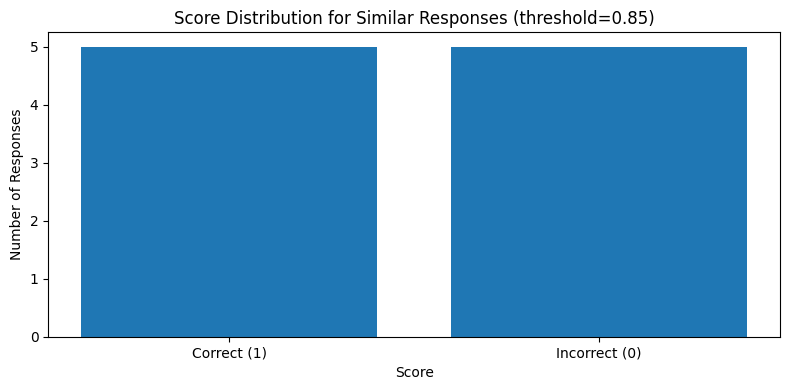


=== PART 2 ===
Response: 'omdat ze dan meer gaan eten dus dan ook meer zuurstof nodig hebben dus ook meer zuurstof op gaan nemen waardoor het zuurstof vermindert en doordat ze dan meer gaan eten en meer zuurstof binnen krijgen geven ze ook meer koolstofdioxide af waardoor het zuurstof vermindert en het koolstofdioxide toeneemt maar ook omdat de organismen toenemen word er meer voortplanting gedaan waardoor er uiteindelijk veel te veel voedsel ontstaat voor andere organismen en de organismen alleen maar toe gaan nemen waardoor er uiteindelijk niet genoeg plek meer is voor alle organismen in de omgeving'
Score: 1

Finding similar responses for part 2...

Found top 10 similar responses (from top 10):



,RESPONSE,SCORE,similarity
1355,als er meer organismen komen verbruiken ze meer zuurstof en ademen ze meer co2 uit,1,0.899613
1726,dit komt doordat er meer organismen komen en zuurstof verbruiken,1,0.899589
641,omdat de organismen het opeten waardoor er ook meer organismen komen en dus ook meer zuurstofverbruik is,1,0.899441
901,"de organisme gaan meer eten en kunnen meer voortplanten, dus komen er meer organisme die meer zuurstof verbruiken",1,0.889827
42,als er meer voetsel met zuurstof op hun leefomgeving komen betekend dat dat er meer organismes zullen zijn omdat er meer eten te halen is.en omdat er genoeg zuurstof in zit kunnen ze daar ook werr van leven.,1,0.888378
401,doordat er heel veel voedselaanbod is. kunnen er dus meer organismen leven waardoor er meer zuurstof verbruikt wordt een dus meer koolstofdioxide vrijkomt.,1,0.886182
2229,doordat er meer organisme zijn hebben ze meer zuurstof nodig,0,0.883619
624,er komen meer organismen die allemaal zuurstof gerbuiken.en er gaat steeds meer zuurstof weg maar het verbruik wordt wel groter,1,0.882731
984,er gebeurd meer als er meer voedingstofen zijn dus komt er meer zuurstof vrij en er komt meer organisme,1,0.881270
1704,omdat meer organismen zuurstof gebruiken aangezien ze meer voedsel hebben.,1,0.880943



Score Distribution:
Correct (score of 1): 9 responses (90.0%)
Incorrect (score of 0): 1 responses (10.0%)


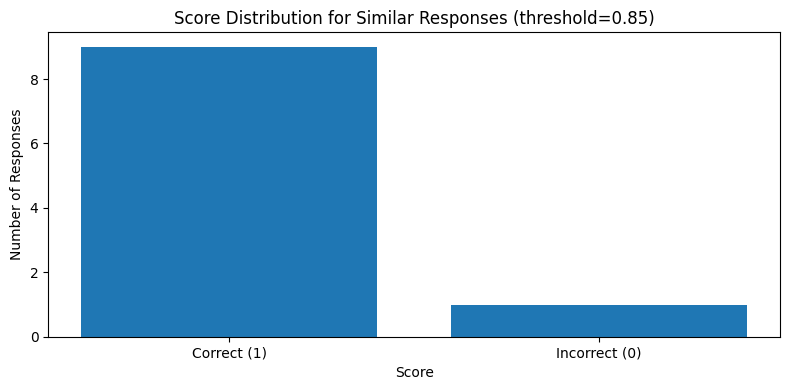


--------------------------------------------------------------------------------

SAMPLE 2/5

=== PART 1 ===
Response: 'dat er minder organisme plaats vind op de zeebodem'
Score: 0

Finding similar responses for part 1...

Found top 10 similar responses (from top 10):



,RESPONSE,SCORE,similarity
1226,er leven minder organismen in het water en meer in de bodem,0,0.883271
718,dat er minder voedsel is voor de organismen boven het water,0,0.874592
485,de organismes bovenaan het water hebben minder voedsel,0,0.853180
438,dat er minder organisme over blijven,0,0.827934
1341,dat er steeds minder organisme is,0,0.824096
583,er is minder voedsel voor de organisme die boven in de vijver zwemmen,0,0.817502
1056,dat er minder organismen blijven leven,0,0.809190
99,is dat er meer reducenten en minder vissen en ander levende organime in de zee,0,0.808315
1067,minder organismen in een vijver waardoor de vissen minder zuurstof zullen krijgen,0,0.798805
577,dat er minder voetsel is voor de organisme.,0,0.794005



Score Distribution:
Correct (score of 1): 0 responses (0.0%)
Incorrect (score of 0): 10 responses (100.0%)


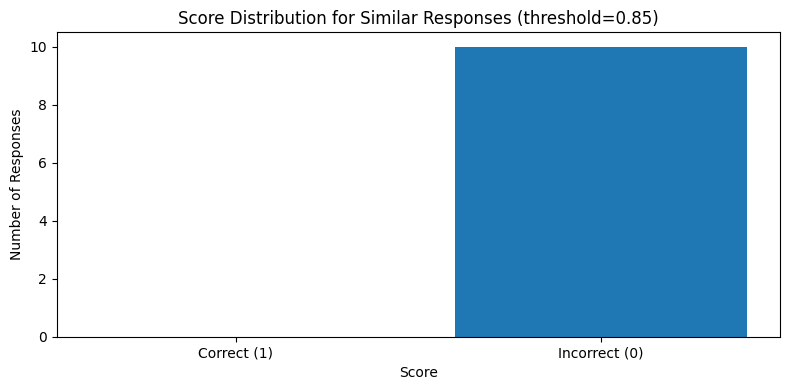


=== PART 2 ===
Response: 'doordat er meer zuurstof verbiukplaatsvind is de kans op overleving weinig waardoor er minder organisme plaats kunnen vinden'
Score: 0

Finding similar responses for part 2...

Found top 10 similar responses (from top 10):



,RESPONSE,SCORE,similarity
1567,als er minder zuurstof is kunnen er ook minder organismen leven en gaat er dus een aantal dood,0,0.917099
1129,doordat er meer organismen zijn word er ook meer zuurstof gebruikt waardoor er dus minder overblijft,1,0.911337
2338,er komen meer organismen dus minder zuurstof,1,0.899250
1245,omdat er iets bijkomt word er meer zuurstof gebruikt en dan hebben die andere organismen minder,0,0.878199
702,als er meer organismen komen dan word er meer zuurstof gebruikt dan wanneer er minder voedsel is en dan dus ook minder organismen.,1,0.878193
2144,zo krijgen de organismes minder zuurstof,0,0.872430
1584,niet erg organisme kan dan voldoende zuurstof bemachtige waardoor het overleven niet meer mogelijk is,0,0.872047
1200,als er meer organismens op de bodem gaan leven blijft er weinig zuurstof over voor alle organismen,1,0.863441
2091,doordat meerdere organisme uit en in ademen is er minder zuurstof,1,0.862399
946,doordat de organismen vermeerderen gebruiken ze meer zuurstof en word het zuurstof dus minder,1,0.861380



Score Distribution:
Correct (score of 1): 6 responses (60.0%)
Incorrect (score of 0): 4 responses (40.0%)


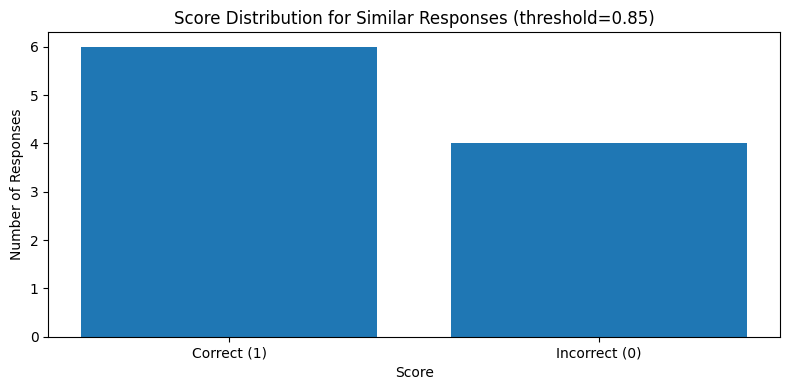


--------------------------------------------------------------------------------

SAMPLE 3/5

=== PART 1 ===
Response: 'dat de organismen op en in de bodem van de vijver meer zuurstof verbruiken.'
Score: 1

Finding similar responses for part 1...

Found top 10 similar responses (from top 10):



,RESPONSE,SCORE,similarity
68,de organismen op de bodem gebruiken minder zuurtof daardoor ontstaat er meer zuurstof in de vijver,0,0.915659
21,"er komen veel meer organismen naar de plek in de vijver toe, zo word er meer zuurstof verbruikt door de organismen.",1,0.906893
429,dat organismen op en in de bodem meer zuurstof gaat gebruiken,1,0.862084
112,"er gaan meer organismen in de vijver wonen/zitten, waardoor het zuurstof gehalte daalt.",1,0.858413
1039,dat de gronddieren in de vijver meer zuustof gaan verbruiken,1,0.857960
339,de organismen hebben meer voedsel wat ze kunnen etenen krijgen zo ook weer meer zuurstof in het water,0,0.857118
399,meer zuurstof gebruik door de organismen oip de bodem,1,0.856251
1175,er wordt meer zuurstof gebruikt door de organismen op de bodem,1,0.854342
1172,de organismen op de bodem krijgen meer zuurstof binnen,0,0.846594
80,"dat er meer organisme in het water komen te leven, en er hierdoor meer zuurstof wordt verbruikt dat er niet is.",1,0.844335



Score Distribution:
Correct (score of 1): 7 responses (70.0%)
Incorrect (score of 0): 3 responses (30.0%)


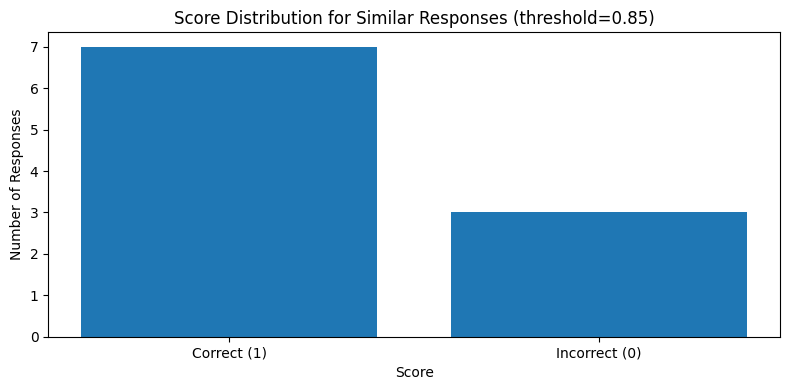


=== PART 2 ===
Response: 'de organismen op en in de bodem van de vijver verbruiken meer zuurstof omdat het voedsel aanbod aanzienelijk vergroot en de meeste organisme daarvan kunnen eten. het kost energie om voedsel te verteren dus er is meer koolstofdioxide die vrij komt. als bijna alle organismen op en in de bodem van de vijver het voedsel gaan verteren komt er van hun allen koolstofdioxide vrij en word en meer zuurstof door hun opgenomen omdat ze veel energie verbruiken bij het benutigen van de grote hoeveelheid voedsel aanbod.'
Score: 1

Finding similar responses for part 2...

Found top 10 similar responses (from top 10):



,RESPONSE,SCORE,similarity
227,"doordat er veel voedsel op de bodem van de vijver ligt, willen de organismen dat natuurlijk consumeren. wanneer dit veel wordt gedaan wordt er ook veel zuurstof verbruikt en te veel koolstofdioxide uitgestoot.",0,0.905451
449,als er meer organismen zijn verbruiken ze meer zuurstof en geven ze meer koolstofdioxide af in het water,1,0.879498
298,doordat de organisch materiaal in de vijver zakken en de organismen meer gaan eten verspillen ze meer energie en hebben ze meer zuurstof nodig om dat energie te kunnen verbruiken,1,0.860011
958,omdat er veel voedsel is wordt er veel zuurstof gebruikt en komt er veel koolstofdioxide in het water,0,0.840761
90,als er veel voedsel is dan komen er meer organismen op af en dan zijn er te veel organismen op een kleine plek en dan is er veel koolstofdioxide en dan is er {veel} minder zuurstof aanwezig in de vijver.,1,0.838809
1803,de organismen op de bode geven meer koolstofdioxide af aan het water\lucht,0,0.838600
406,als de vissen naar de bodem zwemmen kost zuurstof dan eten ze het op en ademen ze het uit en komt er koolstofdioxide vrij dan is er meer koolstofdioxide dan zuurstof,0,0.835026
659,omdat als er veel vissen op de bodem blijfen en daar gaan in en uitademen is er meer koolstofdioxide dan zuurstof,0,0.830274
233,"als er veel voedsel is, komen er veel organismen in de bodem die allemaal zuurstof gebruiken en uit het water halen. zo word het water zuurstof arm",1,0.829864
632,omdat er veel voedsel op de bodem is zullen er veel organisme op de bodem van de vijver rondhangen waardoor er meer zuurstof wordt verbruikt,1,0.828712



Score Distribution:
Correct (score of 1): 5 responses (50.0%)
Incorrect (score of 0): 5 responses (50.0%)


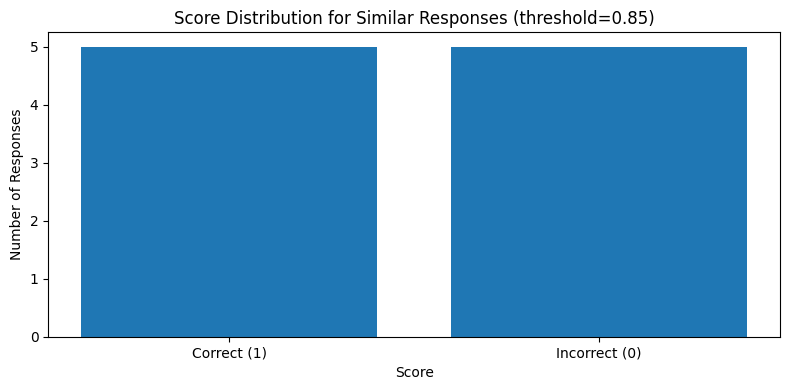


--------------------------------------------------------------------------------

SAMPLE 4/5

=== PART 1 ===
Response: 'er zit minder zuurstof in het water en meer bactieren en schimmels'
Score: 1

Finding similar responses for part 1...

Found top 10 similar responses (from top 10):



,RESPONSE,SCORE,similarity
548,er is minder zuurstof in het water hierdoor gaan meer organismes dood,0,0.908156
762,minder zuurstof voor de organismen die in het water leven.,1,0.903024
244,er is minder zuurstof in het water en organismen gaan dood.,0,0.892627
725,dat de biotische dingen in het water minder zuurstof krijgen,0,0.877407
112,"er gaan meer organismen in de vijver wonen/zitten, waardoor het zuurstof gehalte daalt.",1,0.876147
491,er zitten veel organismen in het water dus daardoor is er niet veel zuurstof,1,0.875588
153,minder zuurstof voor andere organismen in de vijver.,1,0.862550
166,dat er minder zuurstof is omdat er nu meer organismen op af komen,1,0.857812
263,de organismen in de vijver hebbeb minder zuurstof.,0,0.855225
80,"dat er meer organisme in het water komen te leven, en er hierdoor meer zuurstof wordt verbruikt dat er niet is.",1,0.847247



Score Distribution:
Correct (score of 1): 6 responses (60.0%)
Incorrect (score of 0): 4 responses (40.0%)


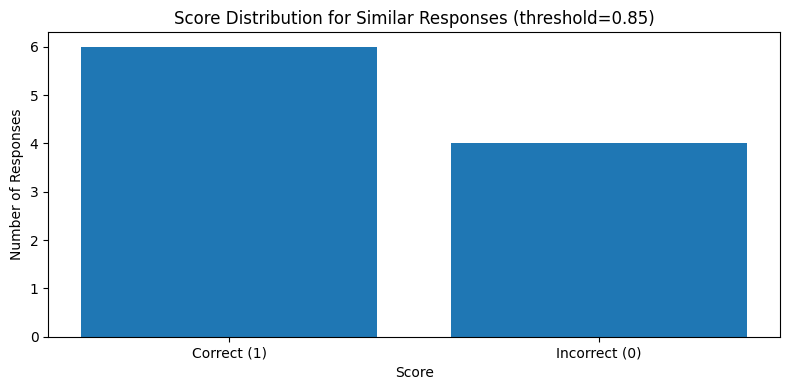


=== PART 2 ===
Response: 'wanneer zoveel vieze uitwerpselen in de bodem komen komen er natuurlijk veel bactieren want het zijn natuurlijk niet voor niks uitwerpselen en die bactieren die gaan zich dan snel vermedigvuldigen en dan komen er ook nog organische stoffen bij die ook natuurlijk erg vies kunnen zijn en dan kunnen ze samen komen en dan komen er super veel bactieren en schimmels en die zuurstof kan dat niet aan waardoor het zuurstofgehalte dus lager word.'
Score: 1

Finding similar responses for part 2...

Found top 10 similar responses (from top 10):



,RESPONSE,SCORE,similarity
307,want het bedekt de bodem waardoor er minder zuurstof is omdat het daar van daan komt en de bacterien die het omzetten in anorganische stof dan langer bezig zijn omdat er veel troep ligt,0,0.871312
952,als er veel resten naar de bodem gaan moeten de bacterien veel zuurtof gebruiken om hjet allemaal weg te halen,0,0.850498
1098,omdat de bacterien enzo op de bodem dan veel verbruiken en die maken zuurstof aan voor in hte water,0,0.849762
1090,doordat alles naar de bodem is gezakt en daat eten de organismen niet van dus de bacterien halen het weg,0,0.834969
1062,vanwege organismen op en in de bodem zullen er veel bacteriã«n aanwezig zijn om het te reproduceren,0,0.828075
783,door dat er te veel op de bodem blijft liggen komen er slechte bacterien vrij en dat kan voor ziekters verzorgen,0,0.816810
253,de bodem kan niet meer goed zuiveren en er zullen dus veel bactieren en schimmels gaan leven. waardoom andere organisem hier weer ziek van kunnen worden.,0,0.815965
1061,uitwerpen gaan naar de bodem en bacterien/schimmels reducenten het en daardoor komt zuurstof uit,0,0.806166
655,niet alles organismen kunnen ales eten en opeten dus er blijven veel resten over en dan raakt de bodem vervuild en kunnen de organismen minder goed ademen,0,0.798043
923,dat komt omdat daar veel dode organismen op de bodem liggen en dat voor veel bacterien zorgen.,0,0.791695



Score Distribution:
Correct (score of 1): 0 responses (0.0%)
Incorrect (score of 0): 10 responses (100.0%)


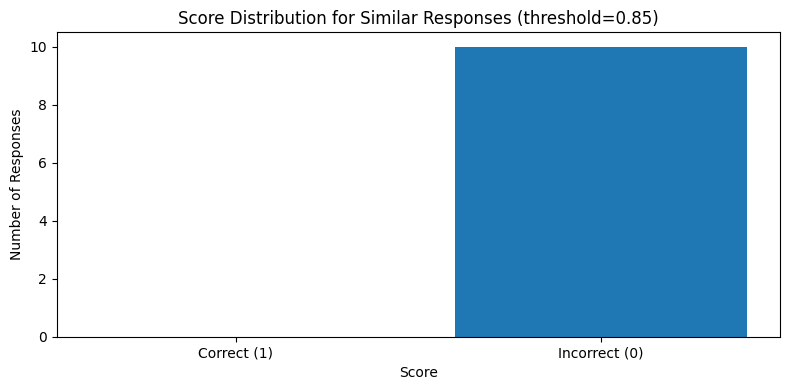


--------------------------------------------------------------------------------

SAMPLE 5/5

=== PART 1 ===
Response: 'groei in populate dat zorgt voor veel meer zuurstof gebruik'
Score: 1

Finding similar responses for part 1...

Found top 10 similar responses (from top 10):



,RESPONSE,SCORE,similarity
641,er komen meer organismen dus het zuurstofverbruik word groter,1,0.875645
1627,dat het zuurstofverbruik meer word,1,0.868241
1028,de zuurstofverbruik word meer,1,0.865316
1370,dat het zuurstof verbruikt meer word,1,0.864496
1030,er word meer zuurstof verbruikt,1,0.864278
729,er word meer zuurstof verbruikt,1,0.864278
209,er word meer zuurstof verbruikt,1,0.864278
1346,het zuurstof gebruik voor hun wordt groter,1,0.864182
1520,de zuurstofgebruik word meer,1,0.863333
1144,meer organisme meer zuurstofverbruik,1,0.862828



Score Distribution:
Correct (score of 1): 10 responses (100.0%)
Incorrect (score of 0): 0 responses (0.0%)


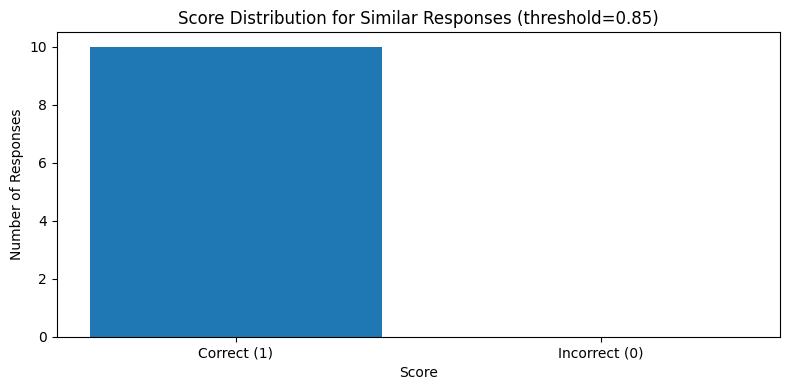


=== PART 2 ===
Response: 'omdat vissen gernalen enz. veel eten worden ze sneller groter en gaan ze sneller paren een gernaal kan tot 100-200 eieren leggen als dat te veel gebeurt word het ecosysteem hele maal in breuken gebracht want dan komen ook weer meer roofdieren omdatze weer meer kunnen eten dat zorgt dat de hogere rang dieren meer eten en meer gaan paren en dit gevolg word uit eindelijk een gebrek aan zuurstof omdat er te veel dieren zijn.'
Score: 1

Finding similar responses for part 2...

Found top 10 similar responses (from top 10):



,RESPONSE,SCORE,similarity
261,vissen hebben meer algen om te eten en die populatie word groter en daar door zullen vogels meer eten hebben en word die populatie grotter,0,0.848576
290,doordat er zoveel voedsel is gaan er meer organismes leven op dat gedeelte ook zal je bijvoorbeeld als vis daar sneller je eitjes leggen omdat je weet dat er veel voedsel is.,1,0.817631
385,"als je een vis hebt die veel voeding heeft kan die langer leven en niet verhongeren, deze kan zich dus langer voortplanten en dus zal de populatie groter worden",1,0.814768
51,er komt meer eten in de vijver voor somige vissen dat zorgt dat die vissen dat gaan eten waardoor de vissen die normaal opgegeten worden groeien in populatie waardoor een vijver arm word in zuurstof,1,0.794356
213,hierdoor blijft er de weinig voedsel over omdat er teveel vissen zijn en er word teveel zuurstof opgenomen dus er gaan meer vissen dood,0,0.786923
24,als er meer voeding is voor de kleine diertjes dan zullen zij meer nakomelingen maken waardoor er een steiging plaats vindt op de bodem van de vijver met als gevolg dat er meer grotere vissen of dieren komen waardoor de toename van organisme in de vijver toeneemt,1,0.774749
892,hoe meer voedsel in het water hoe meer de kans groot is dat de vissen dikker gaan worden.,0,0.773617
83,meer vissen komen naar de vijver toe omdat er veel eten te bieden is er groeien misschien zelfs planten waardoor er meer zuurstof vrij komt,0,0.771596
234,veel vissen dood en die zakken naar de bodem en dan zoals vogels of andere organismens hebben dan veel eten,0,0.770064
257,als er genoeg voelds aan wezig is kunnen de vissen goed eten en zich voort planten daar door zijn er meer vissen maar minder zuursof wand ze moeten samen de zelfde aantal zuurstof gebruiken,1,0.763092



Score Distribution:
Correct (score of 1): 5 responses (50.0%)
Incorrect (score of 0): 5 responses (50.0%)


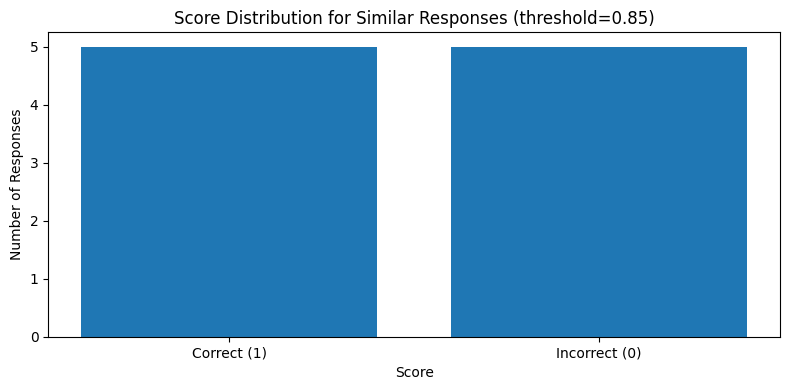


--------------------------------------------------------------------------------



In [32]:
# Analyze the first 5 samples from the first CSV file
pd.set_option('display.max_colwidth', None)

path_0 = csv_paths[0]
results_q1 = analyze_similar_responses_from_path(csv_paths[0], num_samples = 5)